In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [ ]:
# Define the directory and models
models = ["ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2","HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"]  # Replace with actual model names
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/"

# Initialize vmin and vmax
vmin = float("inf")
vmax = float("-inf")

# Dictionary to store relative differences for each model
relative_differences = {}
all_relative_differences = []

# Loop through each model
for model in models:
    # Define paths for BOC and EOC
    path_BOC = os.path.join(diri, model+"_1x1grid/historical/")
    path_EOC = os.path.join(diri, model+"_1x1grid/ssp585/")
    
    # Load BOC files
    files_BOC = [f"{path_BOC}aggregated_solar_power_{year}.nc" for year in range(1980, 2015)]
    datasets_BOC = []
    for year, file in zip(range(1980, 2015), files_BOC):
        ds_BOC = xr.open_dataset(file, engine="netcdf4")
        ds_BOC = ds_BOC.expand_dims(time=[year])
        datasets_BOC.append(ds_BOC)
    combined_ds_BOC = xr.concat(datasets_BOC, dim="time")
    mean_power_BOC = combined_ds_BOC["specific generation"].median(dim="time") #changed to median
    
    # Load EOC files
    files_EOC = [f"{path_EOC}aggregated_solar_power_{year}.nc" for year in range(2065, 2100)]
    datasets_EOC = []
    for year, file in zip(range(2065, 2100), files_EOC):
        ds_EOC = xr.open_dataset(file)
        ds_EOC = ds_EOC.expand_dims(time=[year])
        datasets_EOC.append(ds_EOC)
    combined_ds_EOC = xr.concat(datasets_EOC, dim="time")
    mean_power_EOC = combined_ds_EOC["specific generation"].median(dim="time") #changed to median
    
    # Calculate relative difference
    relative_difference = (mean_power_EOC - mean_power_BOC) / mean_power_BOC * 100
    relative_difference = relative_difference.sel(x=slice(-12, 35), y=slice(33, 65))
    relative_differences[model] = relative_difference
    # Collect all relative differences for global quantile calculation
    all_relative_differences.append(relative_difference)
    
    # Update vmin and vmax
    vmin = min(vmin, relative_difference.min().values)
    vmax = max(vmax, relative_difference.max().values)

# Combine all relative differences into a single array for quantile calculation
all_relative_differences_combined = xr.concat(all_relative_differences, dim="model")
q05, q995 = np.nanpercentile(all_relative_differences_combined, [1, 99.5])

for model, relative_difference in zip(models, all_relative_differences):
    relative_difference = relative_difference
    relative_differences[model] = relative_difference

    


/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/
/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CanESM5_1x1grid/historical/
/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CMCC-CM2-SR5_1x1grid/historical/
/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CMCC-ESM2_1x1grid/historical/
/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-LL_1x1grid/historical/
/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-MM_1x1grid/historical/
/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/MRI-ESM2-0_1x1grid/historical/


In [3]:
def map_plots(variable,
              cmap='viridis',
              setnan=True,
              vmin=None,
              vmax=None,
              title=None,
              label=''):
    """
    Plot a 2D DataArray (x,y) on a PlateCarree map, masking zeros if requested.
    If title is falsy, no title is drawn and the axes are expanded
    symmetrically so the colorbar sits neatly inside.
    """
    # mask zeros→NaN and subset
    if setnan:
        variable = xr.where(variable != 0, variable, np.nan)
    variable = variable.sel(x=slice(-10.5, 34), y=slice(34.5, 62.5))

    lon = variable['x']
    lat = variable['y']

    fig, ax = plt.subplots(
        figsize=(12, 8),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    ax.set_extent([-10.5, 34, 34.5, 62.5], crs=ccrs.PlateCarree())

    mesh = ax.pcolormesh(
        lon, lat, variable,
        transform=ccrs.PlateCarree(),
        cmap=cmap, shading='auto',
        vmin=vmin, vmax=vmax
    )

    # map features
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')

    # only draw a title if non-empty/non-None
    if title:
        ax.set_title(title, fontsize=16)

    # colorbar (shrink lowers its height)
    cbar = fig.colorbar(mesh, ax=ax,
                        orientation='vertical',
                        pad=0.02,
                        shrink=0.8)
    cbar.set_label(label, rotation=90, labelpad=15, fontsize=16)
    cbar.ax.tick_params(labelsize=12)

    # if no title, expand axes symmetrically by δ
    if not title:
        left, bottom, width, height = ax.get_position().bounds
        δ = 0.05
        new_bottom = max(0, bottom - δ/2)
        ax.set_position([left, new_bottom, width, height + δ])

    plt.show()

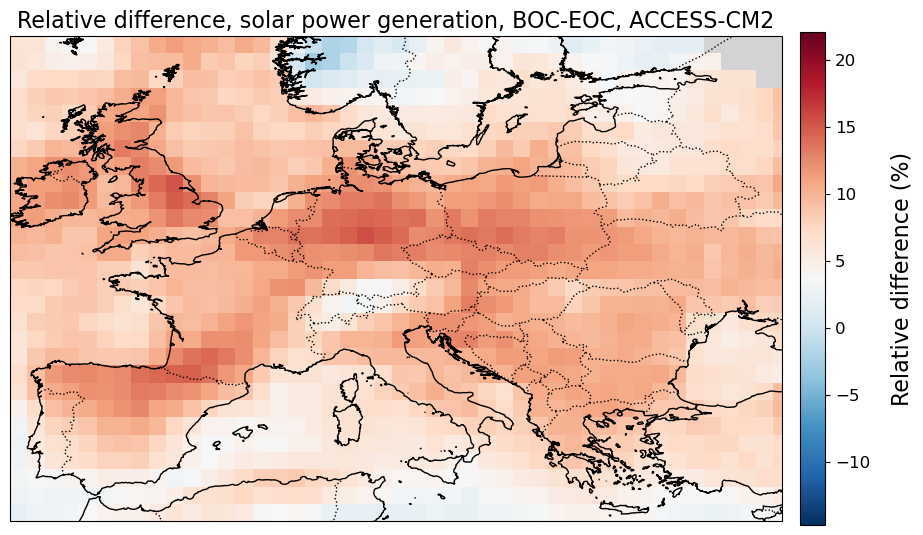

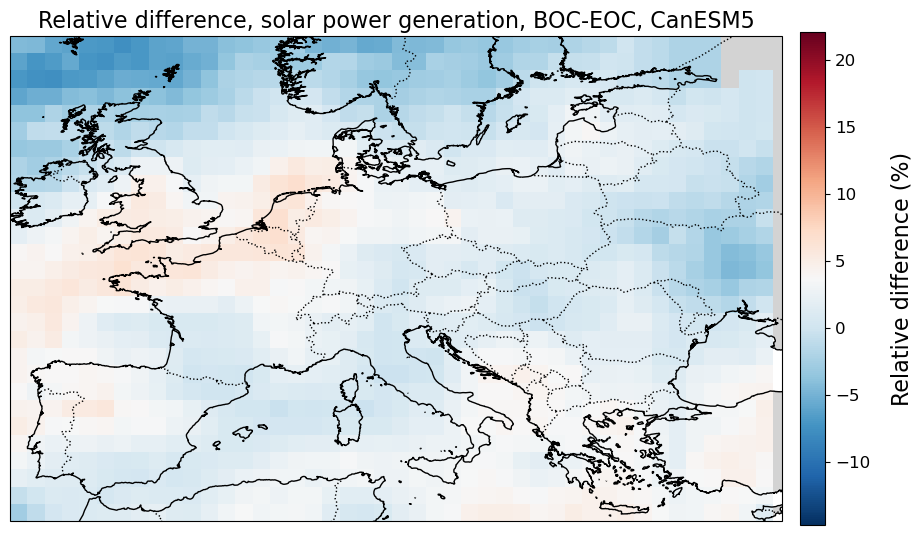

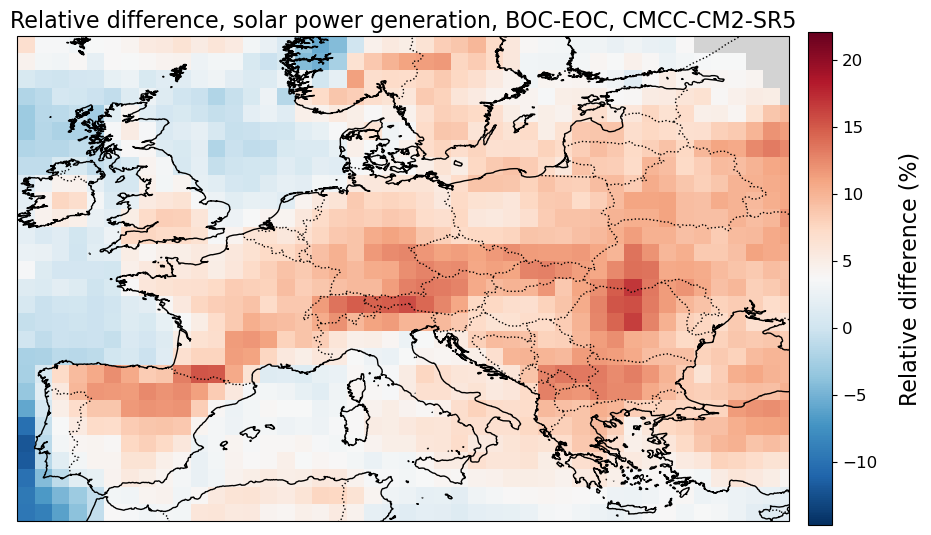

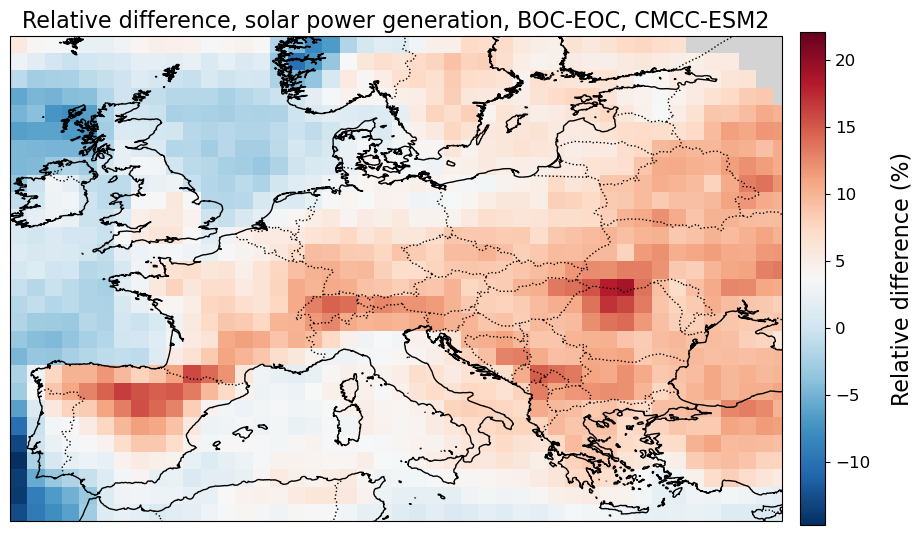

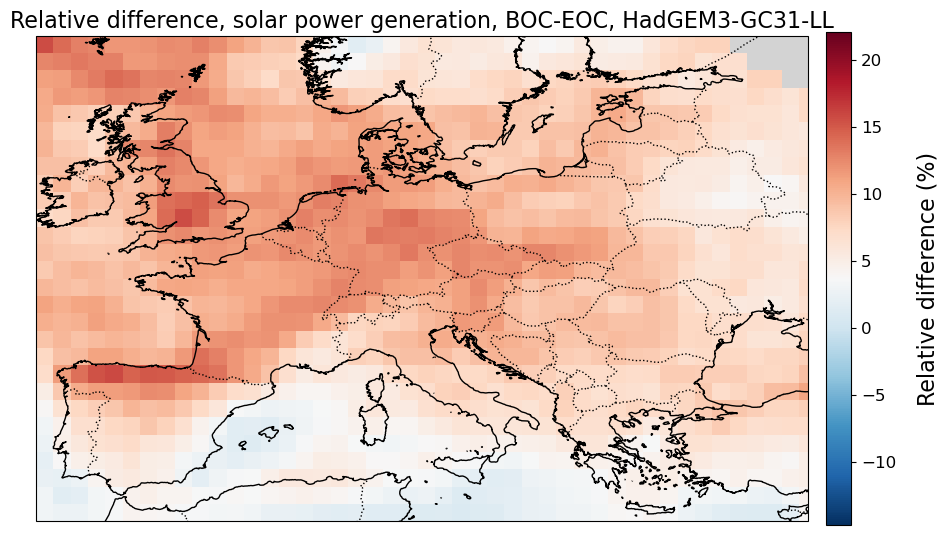

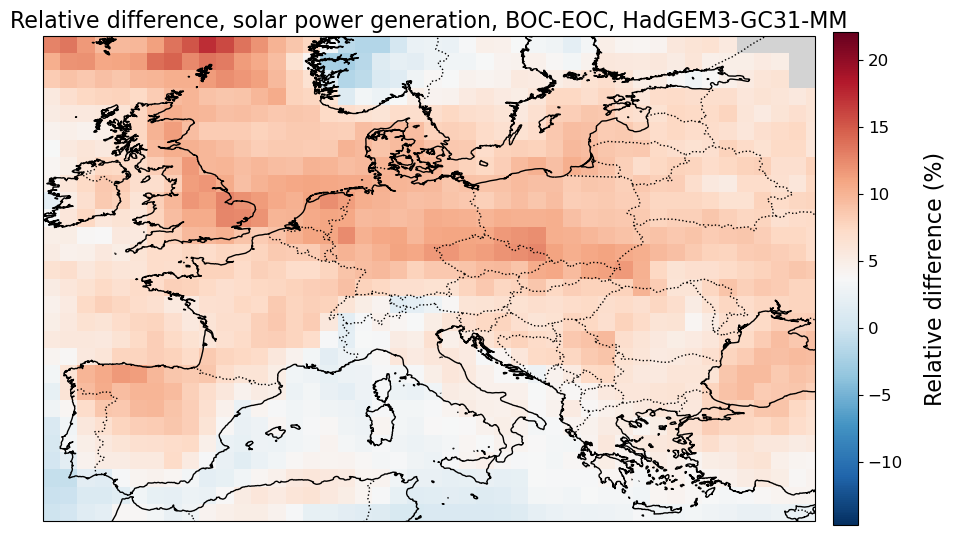

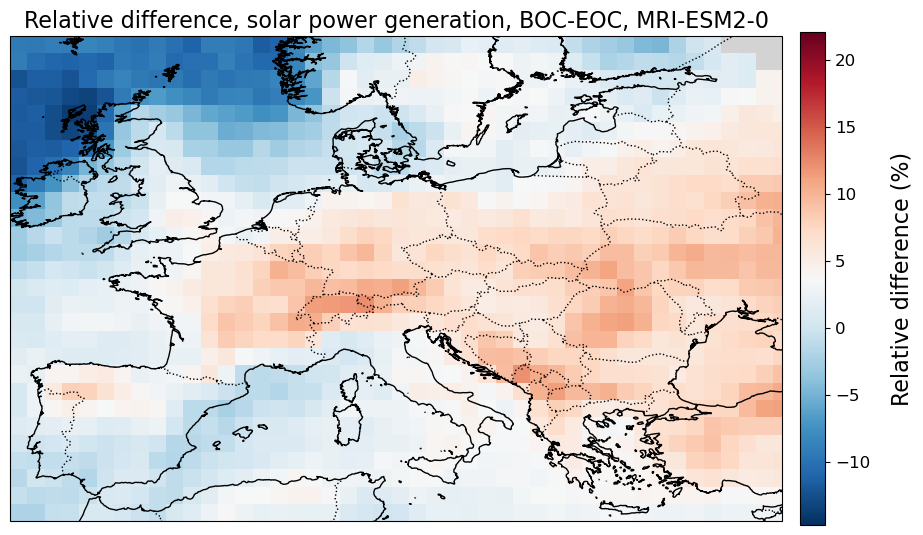

In [4]:
# Plot relative differences for each model
vmin = min(vmin, relative_difference.min().values)
vmax = max(vmax, relative_difference.max().values)
for model, relative_difference in relative_differences.items():
    
    map_plots(relative_difference,cmap='RdBu_r', setnan=False, vmin=vmin, vmax=vmax, title=f"Relative difference, solar power generation, BOC-EOC, {model}", label="Relative difference (%)")
    

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def panel_map_plots_3x3(variables, model_names,
                        cmap='RdBu_r', setnan=True,
                        label='Relative Difference (%)'):
    assert len(variables) == 7 and len(model_names) == 7

    abs_max = 20.0  # Fixed symmetrical scale
    norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)
    ticks = np.arange(-abs_max, abs_max + 1e-6, 5)

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, wspace=0.1, hspace=0.1)

    axes = []
    for i in range(6):  # Top two rows
        row, col = divmod(i, 3)
        ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree())
        axes.append(ax)

    # Bottom row, centered
    ax = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree())
    axes.append(ax)

    # Fill remaining (empty) slots
    for i in [0, 2]:
        ax = fig.add_subplot(gs[2, i])
        ax.axis('off')

    extent = (-10.5, 34, 34.5, 62.5)
    meshes = []

    for da, name, ax in zip(variables, model_names, axes):
        data = da.where(da != 0) if setnan else da
        data = data.sel(x=slice(extent[0], extent[1]),
                        y=slice(extent[2], extent[3]))

        mesh = ax.pcolormesh(data['x'], data['y'], data,
                             transform=ccrs.PlateCarree(),
                             cmap=cmap, norm=norm, shading='auto')
        meshes.append(mesh)

        ax.coastlines(resolution='10m', linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='white')
        ax.set_extent(extent, ccrs.PlateCarree())
        ax.set_title(name, fontsize=18)

    def add_cbar(ax_ref, mesh):
        pos = ax_ref.get_position()
        cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.01, pos.height])
        cb = fig.colorbar(mesh, cax=cax, orientation='vertical', ticks=ticks)
        cb.ax.set_yticklabels([f"{t:.0f}" for t in ticks])
        cb.set_label(label, rotation=90, labelpad=10, fontsize=16)
        cb.ax.tick_params(labelsize=16)

    # Add colorbars for rows 1, 2, 3
    add_cbar(axes[2], meshes[2])
    add_cbar(axes[5], meshes[5])
    add_cbar(axes[6], meshes[6])

    plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/yearly_rel_dif_per_model_1.pdf", bbox_inches='tight', dpi=300)
    plt.show()


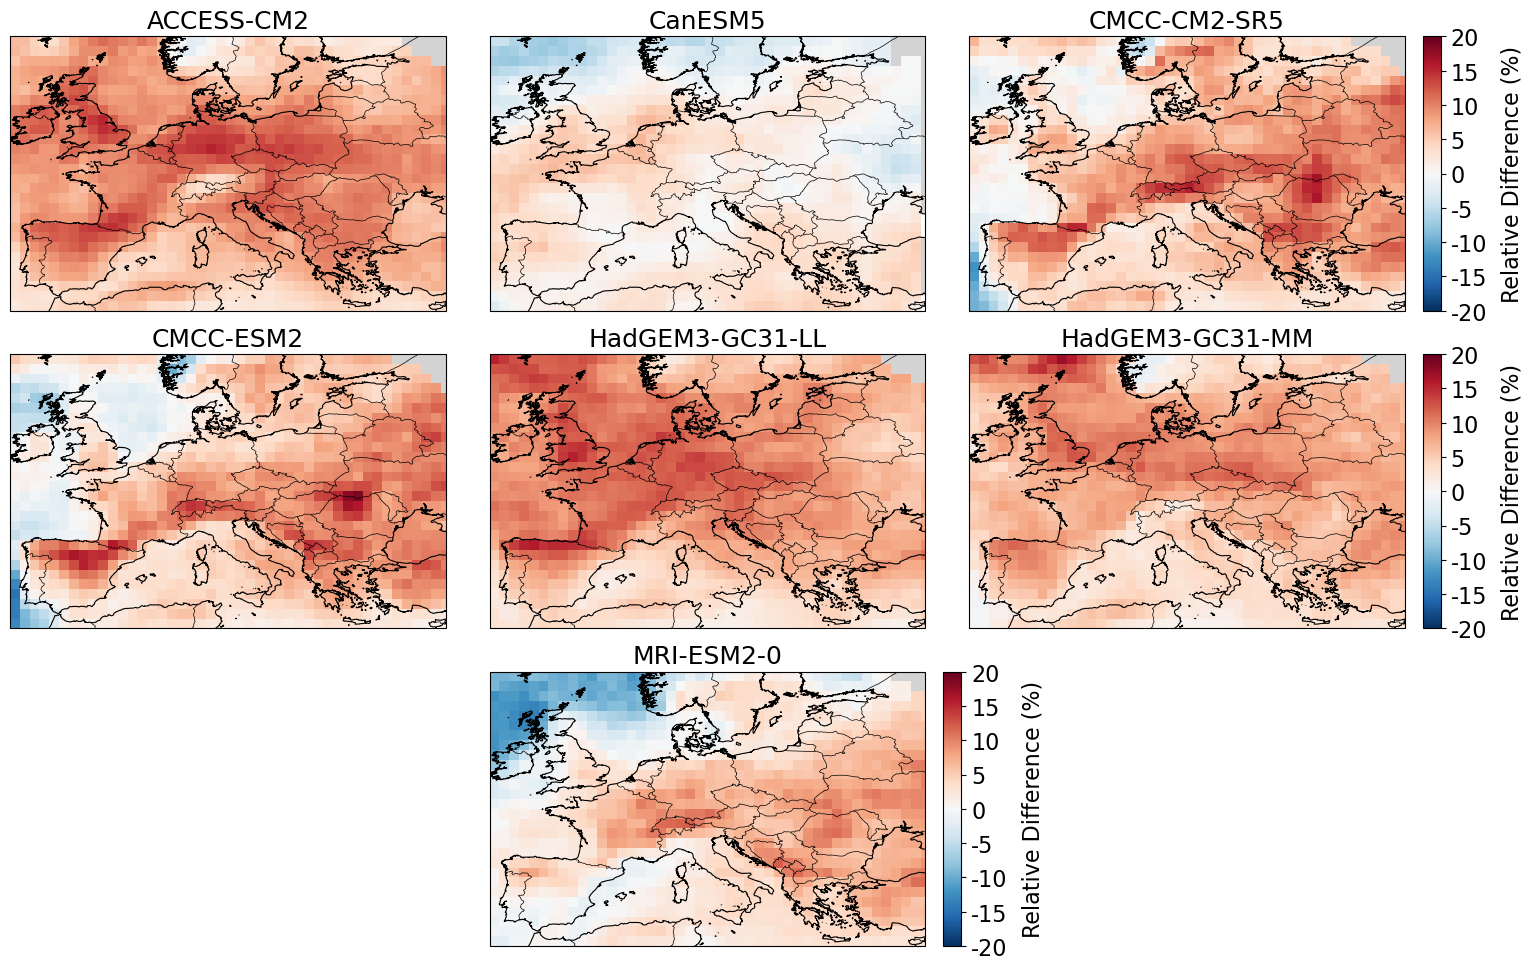

In [6]:
vars_ = list(relative_differences.values())
panel_map_plots_3x3(vars_, models,
                    cmap='RdBu_r',
                    label='Relative Difference (%)')


In [7]:
from matplotlib.colors import TwoSlopeNorm

def map_plots(variable,
              cmap='RdBu_r',  # Updated to a diverging colormap
              setnan=True,
              vmin=None,
              vmax=None,
              title=None,
              label=''):
    """
    Plot a 2D DataArray (x,y) on a PlateCarree map, masking zeros if requested.
    If title is falsy, no title is drawn and the axes are expanded
    symmetrically so the colorbar sits neatly inside.
    """
    # Mask zeros→NaN and subset
    if setnan:
        variable = xr.where(variable != 0, variable, np.nan)
    variable = variable.sel(x=slice(-10.5, 34), y=slice(34.5, 62.5))

    lon = variable['x']
    lat = variable['y']

    # Compute vmin and vmax if not provided
    if vmin is None or vmax is None:
        vmin = variable.min().values
        vmax = variable.max().values

    # Use TwoSlopeNorm to center the colormap at 0
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    fig, ax = plt.subplots(
        figsize=(12, 8),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    ax.set_extent([-10.5, 34, 34.5, 62.5], crs=ccrs.PlateCarree())

    mesh = ax.pcolormesh(
        lon, lat, variable,
        transform=ccrs.PlateCarree(),
        cmap=cmap, shading='auto', norm=norm  # Apply TwoSlopeNorm
    )

    # Map features
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')

    # Only draw a title if non-empty/non-None
    if title:
        ax.set_title(title, fontsize=16)

    # Colorbar (shrink lowers its height)
    cbar = fig.colorbar(mesh, ax=ax,
                        orientation='vertical',
                        pad=0.02,
                        shrink=0.8)
    cbar.set_label(label, rotation=90, labelpad=15, fontsize=16)
    cbar.ax.tick_params(labelsize=12)

    # If no title, expand axes symmetrically by δ
    if not title:
        left, bottom, width, height = ax.get_position().bounds
        δ = 0.05
        new_bottom = max(0, bottom - δ/2)
        ax.set_position([left, new_bottom, width, height + δ])

    # Save the figure
    #plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/median_yearly_rel_dif_nt.pdf", bbox_inches='tight', dpi=300)
    plt.show()

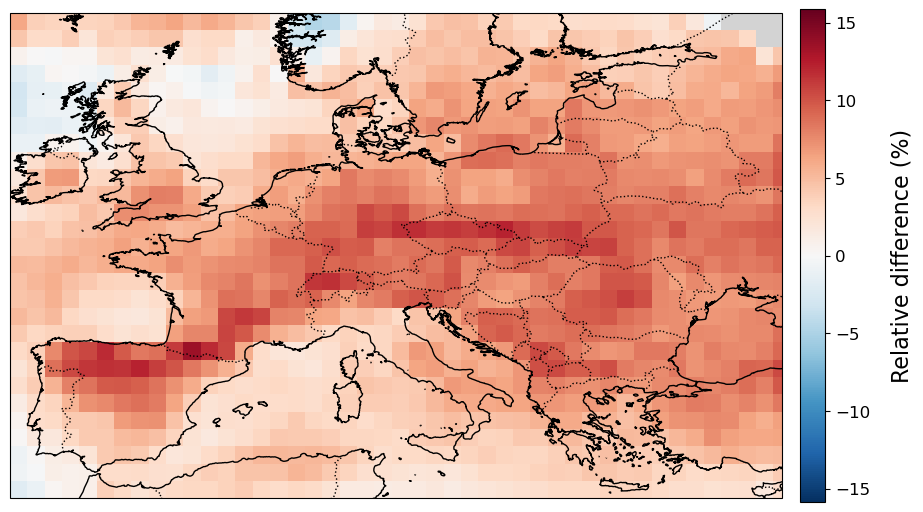

In [8]:
from matplotlib.colors import TwoSlopeNorm

# 1) Compute the multi‐model mean
mean_rel_diff = all_relative_differences_combined.median(dim="model")

# Compute vmin and vmax based on percentiles
vmin = mean_rel_diff.min().values  # Minimum value in the data
vmax = mean_rel_diff.max().values  # Maximum value in the data

# Use TwoSlopeNorm to center the colormap at 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

map_plots(
    mean_rel_diff,
    setnan=False,
    cmap='RdBu_r',
    vmin=-vmax,             # Minimum value
    vmax=vmax,             # Maximum value
    title=None,
    label="Relative difference (%)"
)

In [9]:
def map_plots_discrete(
    variable,
    cmap='viridis',
    setnan=True,
    vmin=None,
    vmax=None,
    norm=None,
    title='',
    label='',
    show_legend=True,        # new flag
):
    """
    Plot a map with discrete categories using a legend instead of a colorbar.

    Parameters:
    - variable: xarray.DataArray, the variable to plot.
    - cmap: str or Colormap, color map to use.
    - setnan: bool, whether to set 0 values as NaN.
    - vmin, vmax: float, value limits.
    - norm: matplotlib.colors.BoundaryNorm, required for discrete bins.
    - title: str, plot title.
    - label: str, legend label title.
    - show_legend: bool, whether to draw the discrete‐category legend.

    Returns:
    - None (displays the plot).
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import matplotlib.ticker as mticker
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.cm as cm
    import xarray as xr
    import numpy as np

    # Mask zeros to NaN if requested
    if setnan:
        variable = xr.where(variable != 0, variable, float('nan'))
    # Clip to your lon/lat region
    variable = variable.sel(x=slice(-12, 35), y=slice(33, 64))

    if variable.isnull().all():
        print("⚠️ All values are NaN — nothing to plot.")
        return

    lon = variable.x
    lat = variable.y

    # resolve cmap
    if isinstance(cmap, str):
        cmap = cm.get_cmap(cmap)

    # figure + map
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-12, 35, 33, 64], crs=ccrs.PlateCarree())

    # assemble pcolormesh kwargs so we never pass vmin/vmax + norm together
    pcol_kwargs = dict(
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        shading='auto'
    )
    if norm is not None:
        pcol_kwargs['norm'] = norm
    else:
        pcol_kwargs['vmin'] = vmin
        pcol_kwargs['vmax'] = vmax

    c = ax.pcolormesh(lon, lat, variable, **pcol_kwargs)

    # add map features
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.set_title(title, fontsize=16)

    # gridlines
    gridlines = ax.gridlines(
        draw_labels=True,
        linewidth=0.5,
        color='gray',
        linestyle='--',
        x_inline=False,
        y_inline=False
    )
    gridlines.xlocator = plt.FixedLocator(lon.values)
    gridlines.ylocator = plt.FixedLocator(lat.values)
    gridlines.xformatter = mticker.FuncFormatter(lambda x, _: f"{x:.2f}")
    gridlines.yformatter = mticker.FuncFormatter(lambda y, _: f"{y:.2f}")
    gridlines.top_labels = False
    gridlines.right_labels = False
    gridlines.xlabel_style = {'fontsize': 12, 'rotation': 45, 'ha': 'right'}
    gridlines.ylabel_style = {'fontsize': 12}
    gridlines.xlines = False
    gridlines.ylines = False

    # optional legend for discrete categories
    if show_legend and norm is not None:
        levels = norm.boundaries[:-1]
        colors = [cmap(norm(level)) for level in levels]
        patches = [
            mpatches.Patch(color=col, label=f"{int(val)}")
            for col, val in zip(colors, levels)
        ]
        ax.legend(
            handles=patches,
            title=label,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            fontsize=10,
            title_fontsize=12,
            frameon=True,
            edgecolor="black",
        )
    plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/sign_agr.pdf", bbox_inches='tight', dpi=300)
    plt.show()


In [10]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

models = ["ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
          "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"]

# Stack & compute agreement_count, mask <2 as before
all_rel = xr.concat([relative_differences[m] for m in models],
                    dim=pd.Index(models, name="model"))
# 2) Ensemble‐mean & sign
ens_mean = all_rel.median(dim="model")
ens_sign = np.sign(ens_mean)

# 3) Agreement count
agreement_count = (np.sign(all_rel) == ens_sign).sum(dim="model")

# 4) Mask everywhere ens_mean is NaN AND everywhere < 2 agree
agreement_count = agreement_count.where(
    (ens_mean.notnull()) & (agreement_count >= 1)
).astype(float)  # Convert to float to allow NaN values
sign_agreement_count = agreement_count.where((agreement_count != 0))

# Replace placeholder values (-9.22337204e+18) with NaN
sign_agreement_count = agreement_count.where(agreement_count > -1e18)

n_colors = len(models)   # 6 distinct agreement levels: 2,3,4,5,6,7

# grab viridis and turn into a discrete ListedColormap
blue = plt.get_cmap("Blues_r", n_colors)
cmap_blues = ListedColormap(blue(np.arange(n_colors)))

# Set NaN values to grey
cmap_blues.set_bad(color="lightgrey")

# reuse the same bins & norm setup as before
bins = np.arange(1, len(models)+2)   # [2,3,4,5,6,7,8]
norm = BoundaryNorm(bins, ncolors=n_colors, clip=False)
ticks = bins[:-1]                    # [2,3,4,5,6,7]

In [17]:
import xarray as xr
# 1. Stack into one DataArray [model, y, x]
all_rel = xr.concat(
    [relative_differences[m] for m in models],
    dim = pd.Index(models, name="model")
)

# 2. Compute the multi‐model mean
ens_mean = all_rel.median(dim="model")

# 3. Define your tolerance (e.g. ±5 % absolute difference)
tol = 5

# 4. Count how many models fall within ±tol of the mean
within_tol = (np.abs(all_rel - ens_mean) <= tol).sum(dim="model")

# 5. Convert to percent agreement
agreement_mag = within_tol

n_colors = len(models)   # 7 distinct agreement levels: 2,3,4,5,6,7

# grab viridis and turn into a discrete ListedColormap
vir = plt.get_cmap("Blues_r", n_colors)
cmap_blue = ListedColormap(vir(np.arange(n_colors)))

# Set NaN values to grey
cmap_blue.set_bad(color="lightgrey")

# reuse the same bins & norm setup as before
bins = np.arange(1, len(models)+2)   # [2,3,4,5,6,7,8]
norm = BoundaryNorm(bins, ncolors=n_colors, clip=False)
ticks = bins[:-1]                    # [2,3,4,5,6,7]

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
from matplotlib.colors import BoundaryNorm, ListedColormap

def map_plots_discrete(
    variables,
    titles,
    subtitles=None,
    categories=None,
    cmaps='Blues',
    setnan=True,
    legend_title='Agreement Levels',
    figsize=(14,6)
):
    # Defaults
    if subtitles is None:
        subtitles = ['', '']
    if categories is None:
        raise ValueError("You must pass a list of integer categories.")
    if isinstance(cmaps, str):
        cmaps = [cmaps, cmaps]
    if len(cmaps) != 2:
        raise ValueError("`cmaps` must be a string or list of two strings.")

    # 1) Mask zeros + clip
    if setnan:
        variables = [xr.where(v != 0, v, np.nan) for v in variables]
    variables = [v.sel(x=slice(-12,35), y=slice(33,64)) for v in variables]

    # 2) All-NaN guard
    if all(v.isnull().all() for v in variables):
        print("⚠️ All values are NaN — nothing to plot.")
        return

    # 3) Discrete norm (shared)
    cats = np.array(categories)
    ncat = len(cats)
    bounds = np.append(cats - 0.5, cats[-1] + 0.5)
    norm = BoundaryNorm(bounds, ncolors=ncat)

    # 4) One ListedColormap per panel
    discrete_cmaps = []
    for cmap_name in cmaps:
        base = plt.get_cmap(cmap_name)
        colors = base(np.linspace(0,1,ncat))
        discrete_cmaps.append(ListedColormap(colors))

    # 5) Figure + axes
    fig, axes = plt.subplots(
        1, 2, figsize=figsize,
        subplot_kw={'projection': ccrs.PlateCarree()},
        gridspec_kw={'wspace': 0.02}
    )

    for ax, data, ttl, sub, cmap_i in zip(
        axes, variables, titles, subtitles, discrete_cmaps
    ):
        ax.set_extent([-12,35,33,64], crs=ccrs.PlateCarree())
        ax.pcolormesh(
            data.x, data.y, data,
            cmap=cmap_i, norm=norm,
            shading='auto',
            transform=ccrs.PlateCarree()
        )
        ax.coastlines('10m', linewidth=1)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='white')

        # main title at 18pt
        ax.set_title(ttl, fontsize=16, pad=12)

        # subtitle up closer, at 18pt
        ax.text(
            0.5, -0.07, sub,
            transform=ax.transAxes,
            ha='center', va='top',
            fontsize=16
        )

        # no labels on gridlines
        gl = ax.gridlines(
            draw_labels=False,
            linewidth=0.5, color='gray', linestyle='--',
            x_inline=False, y_inline=False
        )
        gl.xlines = gl.ylines = False
        ax.set_xticks([]); ax.set_yticks([])

    # 6) Build legend patches
    patches = []
    for cat, color in zip(cats, discrete_cmaps[0].colors):
        # singular “Model” if cat==1, otherwise “Models”
        word = "Model" if cat == 1 else "Models"
        patches.append(
            mpatches.Patch(
                facecolor=color,
                edgecolor='black',
                label=f"{cat} {word}"
            )
        )

    # 7) Room + single legend in 18pt
    fig.subplots_adjust(right=0.80)
    axes[-1].legend(
        handles=patches,
        title=legend_title,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        frameon=True,
        edgecolor='black',
        fontsize=12,
        title_fontsize=12
    )
    plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/mag_agr_sensitivity.pdf", bbox_inches='tight', dpi=300)
    plt.show()




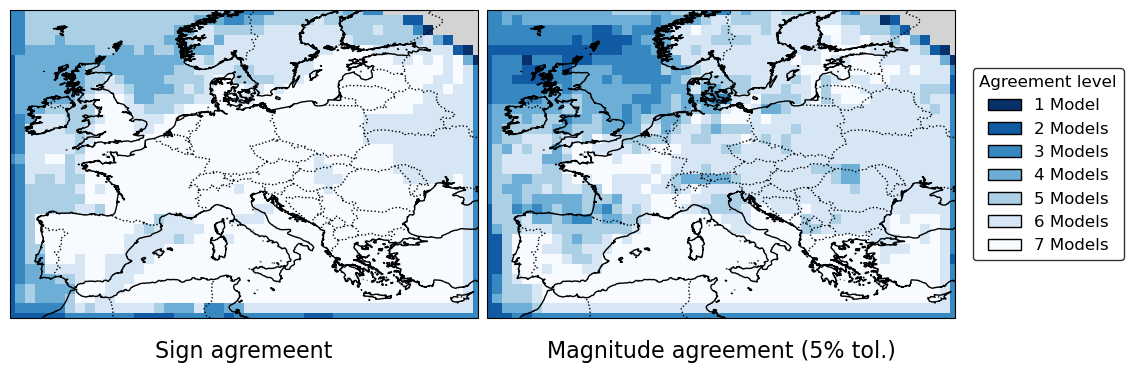

In [18]:

categories=[1,2,3,4,5,6,7]
bounds = np.arange(1, 9)
norm = BoundaryNorm(bounds, ncolors=len(bounds))
variables=[sign_agreement_count, agreement_mag]  # List of DataArrays

map_plots_discrete(
    variables,              # now a list like [var1, var2]
    titles=[None, None], 
    subtitles=["Sign agremeent", "Magnitude agreement (5% tol.)"],
    categories=categories,               # list of two titles, e.g. ['Plot A', 'Plot B']
    cmaps=['Blues_r', "Blues_r"],  # list of two colormaps, e.g. ['Blues', 'Greens'],
    setnan=True,              # same norm for both plots
    legend_title='Agreement level',        # e.g. 'Agreement (%)'
    figsize=(14, 12))


In [19]:
import xarray as xr
# 1. Stack into one DataArray [model, y, x]
all_rel = xr.concat(
    [relative_differences[m] for m in models],
    dim = pd.Index(models, name="model")
)

# 2. Compute the multi‐model mean
ens_mean = all_rel.median(dim="model")

# 3. Define your tolerance (e.g. ±5 % absolute difference)
tol = 4

# 4. Count how many models fall within ±tol of the mean
within_tol_4 = (np.abs(all_rel - ens_mean) <= tol).sum(dim="model")

# 5. Convert to percent agreement
agreement_mag_4 = within_tol_4

In [20]:
# 3. Define your tolerance (e.g. ±5 % absolute difference)
tol = 3

# 4. Count how many models fall within ±tol of the mean
within_tol_3 = (np.abs(all_rel - ens_mean) <= tol).sum(dim="model")

# 5. Convert to percent agreement
agreement_mag_3 = within_tol_3

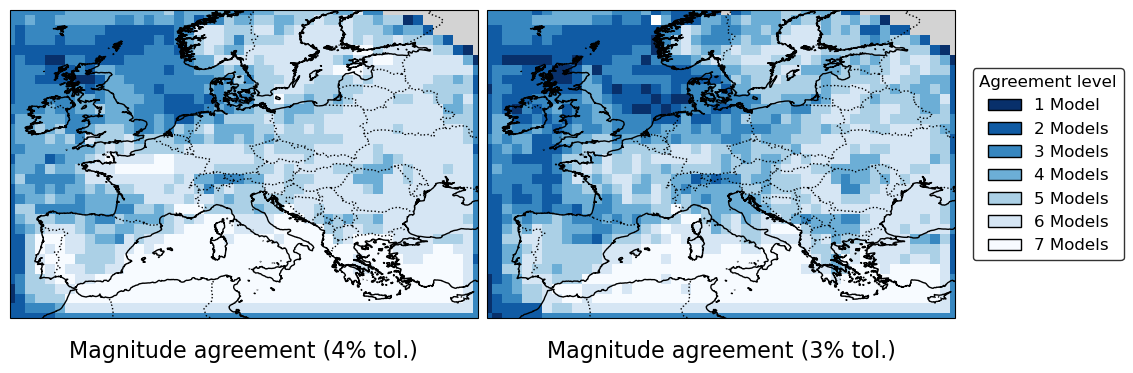

In [21]:

categories=[1,2,3,4,5,6,7]
bounds = np.arange(1, 9)
norm = BoundaryNorm(bounds, ncolors=len(bounds))
variables=[agreement_mag_4, agreement_mag_3]  # List of DataArrays

map_plots_discrete(
    variables,              # now a list like [var1, var2]
    titles=[None, None], 
    subtitles=["Magnitude agreement (4% tol.)", "Magnitude agreement (3% tol.)"],
    categories=categories,               # list of two titles, e.g. ['Plot A', 'Plot B']
    cmaps=['Blues_r', "Blues_r"],  # list of two colormaps, e.g. ['Blues', 'Greens'],
    setnan=True,              # same norm for both plots
    legend_title='Agreement level',        # e.g. 'Agreement (%)'
    figsize=(14, 12))

In [22]:
import os
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box
from scipy.stats import shapiro, ttest_ind

# -------------------------------------------------------------------------
# 1) CONFIGURATION
# -------------------------------------------------------------------------
DIRI = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/"
models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2","HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]

# EU-27 plus all “extras” you want to include
EU27 = [
    'AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
    'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
    'SK','SI','ES','SE','CY'
]
extras = [
    'GB',  # United Kingdom
    'NO',  # Norway
    'BA',  # Bosnia & Herzegovina
    'ME',  # Montenegro
    'RS',  # Serbia
    'AL',  # Albania
    'MK',  # North Macedonia
    'CH',  # Switzerland
    'TR',  # Turkey
    'UA',  # Ukraine
    'BY',  # Belarus
    'MD',  # Moldova
    'RU',  # European Russia
    'XK'   # Kosovo (user-assigned)
]
region_codes = EU27 + extras

years_BOC = range(1980, 2015)   # 1980–2014
years_EOC = range(2065, 2100)   # 2065–2099
data_var  = 'specific generation'

# -------------------------------------------------------------------------
# 2) BUILD 1°×1° GRID-CELL POLYGONS
# -------------------------------------------------------------------------
sample_fp = os.path.join(
    DIRI,
    f"{models[0]}_1x1grid/historical/aggregated_solar_power_{years_BOC[0]}.nc"
)
ds_sample = xr.open_dataset(sample_fp, engine='netcdf4')
lats = ds_sample['lat'].values
lons = ds_sample['lon'].values
ds_sample.close()

dlat = float(np.diff(lats).mean())
dlon = float(np.diff(lons).mean())

cells = []
for lat in lats:
    for lon in lons:
        cells.append({
            'lon': float(lon),
            'lat': float(lat),
            'geometry': box(
                lon - dlon/2, lat - dlat/2,
                lon + dlon/2, lat + dlat/2
            )
        })
gdf_cells = gpd.GeoDataFrame(cells, crs="EPSG:4326")

# -------------------------------------------------------------------------
# 3) LOAD & FILTER COUNTRIES (EU27 + EXTRAS)
# -------------------------------------------------------------------------
ne50 = (
    "https://naturalearth.s3.amazonaws.com/50m_cultural/"
    "ne_50m_admin_0_countries.zip"
)
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world['NAME_LONG']=='France', 'ISO_A2'] = 'FR'
world.loc[world['NAME_LONG']=='Norway', 'ISO_A2'] = 'NO'

# 2) Assign Kosovo’s ISO if it exists by NAME_LONG or some other field
mask_kosovo = world['NAME_LONG'] == 'Kosovo'
if mask_kosovo.any():
    world.loc[mask_kosovo, 'ISO_A2'] = 'XK'
else:
    # if it wasn’t there at all, you could manually pull it from a 1:10m file or add it:
    kosovo = gpd.read_file("path/to/ne_10m_admin_0_countries.shp")
    kosovo = kosovo[kosovo['NAME_LONG']=='Kosovo'][['geometry']].copy()
    kosovo['ISO_A2'] = 'XK'
    world = pd.concat([world, kosovo], ignore_index=True)

# 3) Now filter your region of interest:
eu_plus = world[world['ISO_A2'].isin(region_codes)][['ISO_A2','geometry']].copy()

# -------------------------------------------------------------------------
# 4) INTERSECT & COMPUTE GRID-CELL WEIGHTS
# -------------------------------------------------------------------------
proj_crs = "EPSG:3035"
cells_pa = gdf_cells.to_crs(proj_crs)
cells_pa['cell_area'] = cells_pa.geometry.area
eu_pa = eu_plus.to_crs(proj_crs)

inter = gpd.overlay(cells_pa, eu_pa, how='intersection')
inter['overlap_area'] = inter.geometry.area
inter['weight'] = inter['overlap_area'] / inter['cell_area']
inter = inter[['lon','lat','ISO_A2','weight']].reset_index(drop=True)

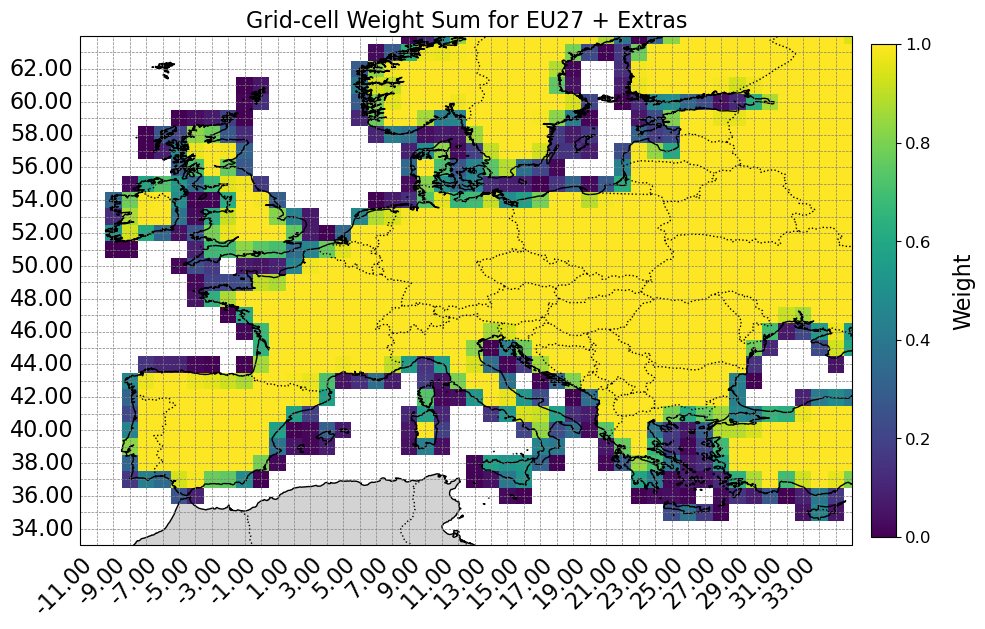

In [23]:
# group and sum weights across countries for each (lon,lat)
df_ws = (
    inter
    .groupby(['lon','lat'])['weight']
    .sum()
    .reset_index(name='total_weight')
)

# 2) Build a wide 2D weight array on your lon/lat grid
# -----------------------------------------------------------------------------
lons = np.array(sorted(gdf_cells['lon'].unique()))
lats = np.array(sorted(gdf_cells['lat'].unique()))

wt_mat = np.full((len(lats), len(lons)), np.nan)

# fill it in from the summed‐weights table
for lon, lat, w in zip(df_ws['lon'], df_ws['lat'], df_ws['total_weight']):
    i = np.searchsorted(lons, lon)
    j = np.searchsorted(lats, lat)
    wt_mat[j, i] = w

# 3) Wrap it up in an xarray.DataArray with dims x=lon, y=lat
# -----------------------------------------------------------------------------
weight_da = xr.DataArray(
    wt_mat,
    coords={'x': lons, 'y': lats},
    dims=('y', 'x'),
    name='cell_weight'
)

from plots import map_plots
map_plots(
    weight_da,
    cmap='viridis',
    setnan=True,      # hides the NaN (cells outside region)
    vmin=0.0,
    vmax=1.0,
    title='Grid‐cell Weight Sum for EU27 + Extras',
    label='Weight'
)


/tmp/ipykernel_54496/1627807203.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  full = eu_plus[eu_plus['ISO_A2']==iso].geometry.unary_union
/tmp/ipykernel_54496/1627807203.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  full = eu_plus[eu_plus['ISO_A2']==iso].geometry.unary_union
/tmp/ipykernel_54496/1627807203.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  full = eu_plus[eu_plus['ISO_A2']==iso].geometry.unary_union
/tmp/ipykernel_54496/1627807203.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  full = eu_plus[eu_plus['ISO_A2']==iso].geometry.unary_union
/tmp/ipykernel_54496/1627807203.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  full = eu_plus[eu_plus['ISO_A2']==iso].geometry.un

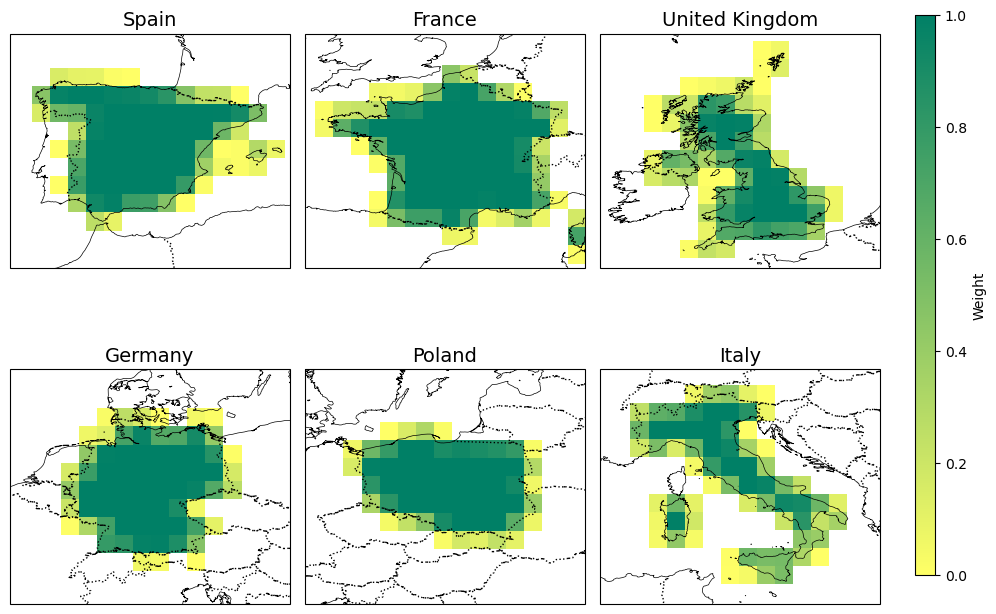

In [24]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1) Define your focus ISOs and precompute weight mats as before
focus = ['ES','FR','GB','DE','PL','IT']
lons = np.array(sorted(gdf_cells['lon'].unique()))
lats = np.array(sorted(gdf_cells['lat'].unique()))

weight_iso = {}
for iso in focus:
    df = inter[inter['ISO_A2']==iso]
    mat = np.full((len(lats), len(lons)), np.nan)
    for lon, lat, w in zip(df['lon'], df['lat'], df['weight']):
        i = np.searchsorted(lons, lon)
        j = np.searchsorted(lats, lat)
        mat[j, i] = w
    weight_iso[iso] = mat

# 2) Build “mainland” geometries and their raw bboxes
country_geoms = {}
bboxes = {}
for iso in focus:
    full = eu_plus[eu_plus['ISO_A2']==iso].geometry.unary_union
    if iso in ('ES','FR') and full.geom_type == 'MultiPolygon':
        main = max(full.geoms, key=lambda p: p.area)
        geom = main
    else:
        geom = full
    country_geoms[iso] = geom
    minx, miny, maxx, maxy = geom.bounds
    bboxes[iso] = (minx, miny, maxx, maxy)

# 3) Compute the max width & height across all countries
widths  = [bboxes[iso][2] - bboxes[iso][0] for iso in focus]
heights = [bboxes[iso][3] - bboxes[iso][1] for iso in focus]
maxW, maxH = max(widths), max(heights)

# add a small relative buffer (10%)
bufW, bufH = 0.1 * maxW, 0.1 * maxH

# 4) Create 2×3 panels, all with the SAME lon/lat span
fig, axes = plt.subplots(
    2, 3, figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for ax, iso in zip(axes.flat, focus):
    # wrap weights into a DataArray for plotting
    da = xr.DataArray(
        weight_iso[iso],
        coords={'x': lons, 'y': lats},
        dims=('y','x')
    )

    # plot the cell‐weights
    pcm = ax.pcolormesh(
        lons, lats, da,
        cmap='summer_r', vmin=0, vmax=1,
        shading='auto',
        transform=ccrs.PlateCarree()
    )
    focus = ['ES','FR','GB','DE','PL','IT']
    country_names = ["Spain", "France", "United Kingdom", "Germany", "Poland", "Italy"]
    iso_to_name = dict(zip(focus, country_names))
    ax.coastlines('10m', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(iso_to_name[iso], fontsize=14)

    # compute the *center* of this country’s bbox
    minx, miny, maxx, maxy = bboxes[iso]
    cx, cy = 0.5*(minx+maxx), 0.5*(miny+maxy)

    # set the *same* window size for every panel
    ax.set_extent(
        [cx - maxW/2 - bufW, cx + maxW/2 + bufW,
         cy - maxH/2 - bufH, cy + maxH/2 + bufH],
        crs=ccrs.PlateCarree()
    )

# shared colorbar
# collect all subplot axes
# shared colorbar on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cbar_ax, label='Weight')
#fig.suptitle(
#    "Per-cell Weight for Selected Countries",
#    fontsize=16, y=0.85
#)
plt.tight_layout(rect=[0,0,0.9,0.94])
plt.show()


In [ ]:
DIRI= "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/"
years_BOC = range(1980, 2015)   # 1980–2014
years_EOC = range(2065, 2100)   # 2065–2099
data_var  = 'specific generation'
# -------------------------------------------------------------------------
# 5) HELPER: SUM-WEIGHTED AGGREGATION TO COUNTRY
# -------------------------------------------------------------------------
def country_aggregated(da, inter_gdf):
    df = da.to_dataframe(name='P').reset_index()  # lat, lon, P
    df = df.merge(inter_gdf, on=['lon','lat'], how='inner')
    df['contrib'] = df['P'] * df['weight']
    return df.groupby('ISO_A2')['contrib'].sum()

# -------------------------------------------------------------------------
# 6) LOOP MODELS & YEARS → RECORD PER-YEAR TOTALS
# -------------------------------------------------------------------------
records = []
for model in models:
    # BOC period
    boc_dir = os.path.join(DIRI, f"{model}_1x1grid/historical/")
    for yr in years_BOC:
        fp = os.path.join(boc_dir, f"aggregated_solar_power_{yr}.nc")
        ds = xr.open_dataset(fp, engine='netcdf4')
        da = ds[data_var]; ds.close()
        ct = country_aggregated(da, inter)
        for iso, val in ct.items():
            records.append({
                'model':  model,
                'period': 'BOC',
                'year':   yr,
                'ISO_A2': iso,
                'value':  float(val)
            })

    # EOC period
    eoc_dir = os.path.join(DIRI, f"{model}_1x1grid/ssp585/")
    for yr in years_EOC:
        fp = os.path.join(eoc_dir, f"aggregated_solar_power_{yr}.nc")
        ds = xr.open_dataset(fp, engine='netcdf4')
        da = ds[data_var]; ds.close()
        ct = country_aggregated(da, inter)
        for iso, val in ct.items():
            records.append({
                'model':  model,
                'period': 'EOC',
                'year':   yr,
                'ISO_A2': iso,
                'value':  float(val)
            })

df = pd.DataFrame.from_records(records)

# -------------------------------------------------------------------------
# 7a) PER-MODEL, PER-COUNTRY STATS (ALL region_codes)
# -------------------------------------------------------------------------
model_records = []
alpha = 0.05

for iso in region_codes:
    for model in models:
        boc_vals = df.query(
            "ISO_A2 == @iso and model == @model and period == 'BOC'"
        )['value'].values
        eoc_vals = df.query(
            "ISO_A2 == @iso and model == @model and period == 'EOC'"
        )['value'].values

        if len(boc_vals) < 3 or len(eoc_vals) < 3:
            continue

        # Shapiro–Wilk normality tests
        _, p_s_b = shapiro(boc_vals)
        _, p_s_e = shapiro(eoc_vals)
        # Welch’s t-test
        _, p_tt  = ttest_ind(eoc_vals, boc_vals, equal_var=False)

        m_b = np.median(boc_vals)
        m_e = np.median(eoc_vals)
        rel = (m_e - m_b) / m_b * 100

        model_records.append({
            'ISO_A2':        iso,
            'model':         model,
            'median_BOC':      m_b,
            'median_EOC':      m_e,
            'rel_change_%':  rel,
            'p_shapiro_BOC': p_s_b,
            'p_shapiro_EOC': p_s_e,
            'p_ttest':       p_tt,
            'signif_ttest':  (p_tt < alpha)
        })

model_stats_df = pd.DataFrame(model_records)
#model_stats_df.to_csv('solar_country_model_stats.csv', index=False)
#print("Wrote per-model stats to solar_country_model_stats.csv")


# -------------------------------------------------------------------------
# 7b) SUMMARY PER COUNTRY (ALL region_codes)
# -------------------------------------------------------------------------
summary = (
    model_stats_df
    .groupby('ISO_A2')
    .apply(lambda g: pd.Series({
        'n_models_tested':      len(g),
        'n_models_significant': int(g['signif_ttest'].sum()),
        'median_rel_change_sig':  float(g.loc[g['signif_ttest'], 'rel_change_%'].mean())
    }))
)

# Reindex to include every ISO in region_codes, even if missing
summary = summary.reindex(region_codes)

# For countries not present, set counts to zero (leave mean_rel_change_sig as NaN)
summary['n_models_tested'] = summary['n_models_tested'].fillna(0).astype(int)
summary['n_models_significant'] = summary['n_models_significant'].fillna(0).astype(int)

#generate solar statistics summary
#summary.to_csv('solar_stats_per_country_summary.csv')
#print("Wrote country summary to solar_stats_per_country_summary.csv")
print(summary)

        n_models_tested  n_models_significant  median_rel_change_sig
ISO_A2                                                              
AT                    7                     6               9.430420
BE                    7                     7               8.424547
BG                    7                     7               7.797283
HR                    7                     6               8.169618
CZ                    7                     6              10.247218
DK                    7                     6               6.384509
EE                    7                     6               4.908968
FI                    7                     5               4.379582
FR                    7                     7               7.505847
DE                    7                     7               8.131509
GR                    7                     7               5.959716
HU                    7                     6               8.320033
IE                    7           

/tmp/ipykernel_54496/528580879.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


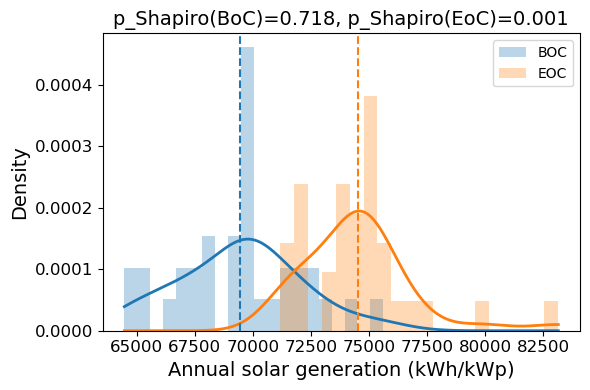

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

target_iso = "FR"     # example: Austria
target_model = "HadGEM3-GC31-MM"  # example model
# significance threshold
alpha = 0.05

# select only the “flagged” country-model combos
flagged = model_stats_df[
    (model_stats_df['signif_ttest'] == True) &
    (
        (model_stats_df['p_shapiro_BOC'] < alpha) |
        (model_stats_df['p_shapiro_EOC'] < alpha)
    )
]

boc_color = 'tab:blue'
eoc_color = 'tab:orange'

for _, row in flagged.iterrows():
    
    iso   = row['ISO_A2']
    model = row['model']
    if iso != target_iso or model != target_model:
        continue  # skip everything else
    
    # pull out the BOC/EOC time-series for this country+model
    boc_vals = df.loc[
        (df.ISO_A2  == iso) &
        (df.model   == model) &
        (df.period  == 'BOC'),
        'value'
    ].values
    eoc_vals = df.loc[
        (df.ISO_A2  == iso) &
        (df.model   == model) &
        (df.period  == 'EOC'),
        'value'
    ].values

    if boc_vals.size == 0 or eoc_vals.size == 0:
        continue

    # common support for KDE
    xs = np.linspace(
        min(boc_vals.min(), eoc_vals.min()),
        max(boc_vals.max(), eoc_vals.max()),
        300
    )
    kde_boc = gaussian_kde(boc_vals)
    kde_eoc = gaussian_kde(eoc_vals)

    plt.figure(figsize=(6, 4))
    # histograms
    plt.hist(boc_vals, bins=20, density=True,
             color=boc_color, alpha=0.3, label='BOC')
    plt.hist(eoc_vals, bins=20, density=True,
             color=eoc_color, alpha=0.3, label='EOC')
    # KDE curves
    plt.plot(xs, kde_boc(xs), color=boc_color, lw=2)
    plt.plot(xs, kde_eoc(xs), color=eoc_color, lw=2)
    # mean lines
    plt.axvline(boc_vals.mean(), color=boc_color,
                linestyle='--', lw=1.5)
    plt.axvline(eoc_vals.mean(), color=eoc_color,
                linestyle='--', lw=1.5)

    plt.title(
        #f'{iso} — {model}\n'
        f'p_Shapiro(BoC)={row["p_shapiro_BOC"]:.3f}, '
        f'p_Shapiro(EoC)={row["p_shapiro_EOC"]:.3f}', fontsize=14
    )
    plt.xlabel('Annual solar generation (kWh/kWp)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)  # <-- Add this line
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/{iso}_{model}_distribution.pdf",bbox_inches='tight', dpi=300)
    plt.show()


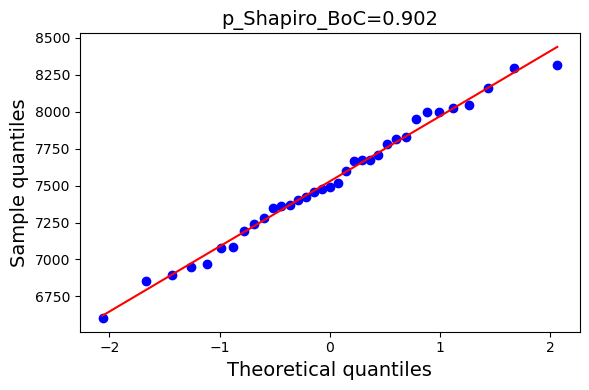

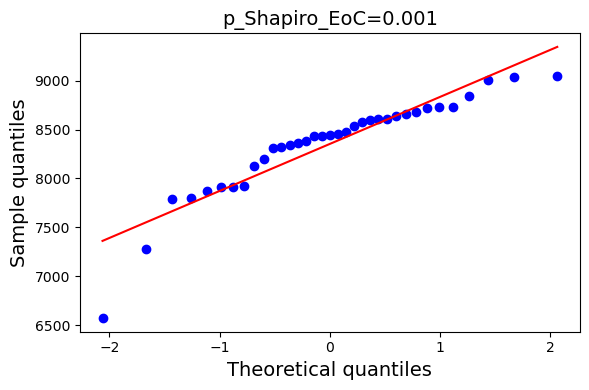

In [28]:
from scipy.stats import probplot
target_iso = "AT"     # example: Austria
target_model = "CMCC-CM2-SR5"  # example model

for _, row in flagged.iterrows():
    iso   = row['ISO_A2']
    model = row['model']

    if iso != target_iso or model != target_model:
        continue  # Skip other entries

    boc_vals = df.loc[
        (df.ISO_A2 == iso) & (df.model == model) & (df.period == 'BOC'),
        'value'
    ].values
    eoc_vals = df.loc[
        (df.ISO_A2 == iso) & (df.model == model) & (df.period == 'EOC'),
        'value'
    ].values

    if boc_vals.size == 0 or eoc_vals.size == 0:
        continue

    # ---- Q–Q plot for BOC ----
    plt.figure(figsize=(6, 4))
    probplot(boc_vals, dist="norm", plot=plt)
    plt.title(f'p_Shapiro_BoC={row["p_shapiro_BOC"]:.3f}', fontsize=14)
    plt.xlabel('Theoretical quantiles', fontsize=14)
    plt.ylabel('Sample quantiles', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/{iso}_{model}_QQ_BOC.pdf", bbox_inches='tight', dpi=300)
    plt.show()

    # ---- Q–Q plot for EOC ----
    plt.figure(figsize=(6, 4))
    probplot(eoc_vals, dist="norm", plot=plt)
    plt.title(f'p_Shapiro_EoC={row["p_shapiro_EOC"]:.3f}', fontsize=14)
    plt.xlabel('Theoretical quantiles', fontsize=14)
    plt.ylabel('Sample quantiles', fontsize=14)
    plt.tight_layout()
    #plt.savefig(f"/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/{iso}_{model}_QQ_EOC.pdf", bbox_inches='tight', dpi=300)
    plt.show()
    
    break  # stop after this one if only one match is needed


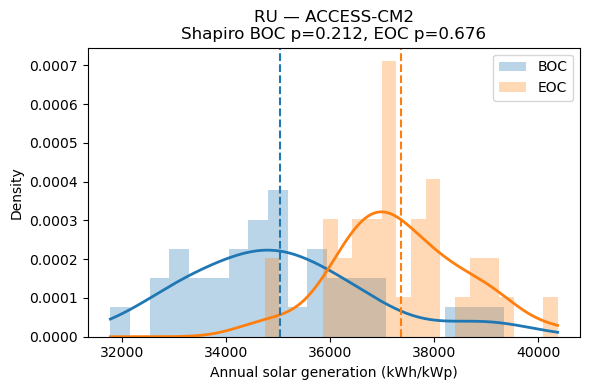

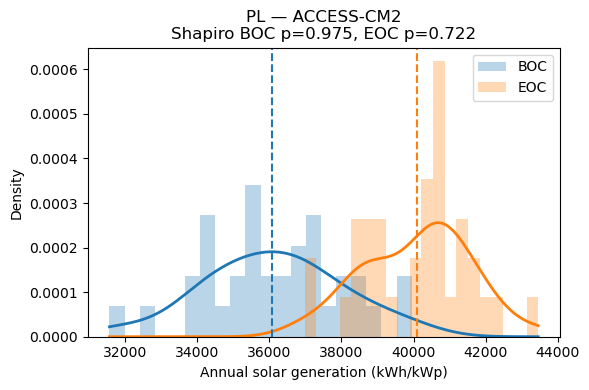

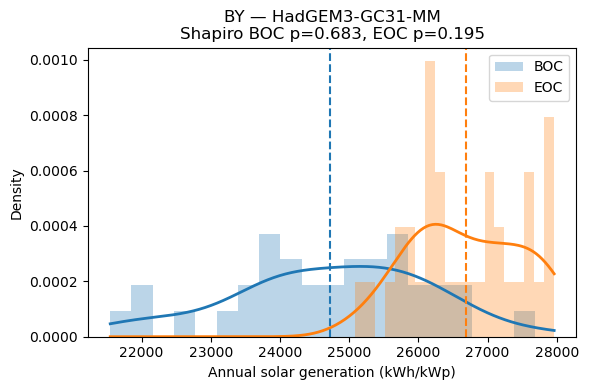

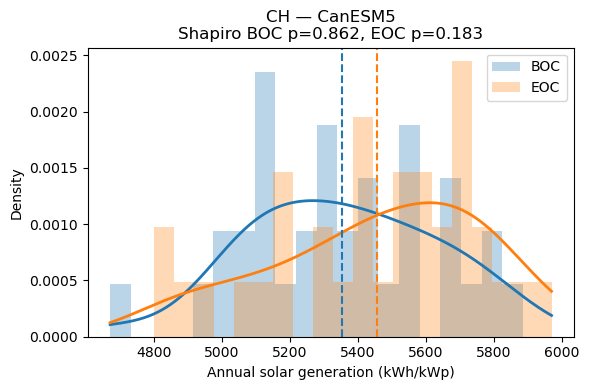

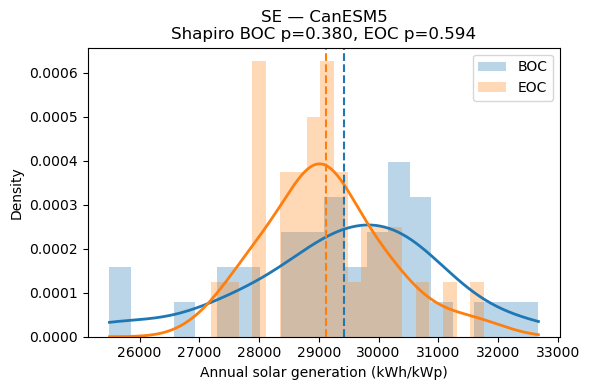

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

alpha = 0.05

# 1) Select “normal” cases: both Shapiro p-values ≥ 0.05
normal = model_stats_df[
    (model_stats_df['p_shapiro_BOC'] >= alpha) &
    (model_stats_df['p_shapiro_EOC'] >= alpha)
]

# 2) Randomly pick five distinct (ISO_A2,model) pairs
#    You can also pick the “first” five or choose by hand.
examples = normal.sample(n=5, random_state=0)[['ISO_A2','model']]

boc_color = 'tab:blue'
eoc_color = 'tab:orange'

for _, row in examples.iterrows():
    iso   = row['ISO_A2']
    model = row['model']

    # extract time-series for this pair
    boc_vals = df.loc[
        (df.ISO_A2 == iso) &
        (df.model  == model) &
        (df.period == 'BOC'),
        'value'
    ].values
    eoc_vals = df.loc[
        (df.ISO_A2 == iso) &
        (df.model  == model) &
        (df.period == 'EOC'),
        'value'
    ].values

    # build x-axis for KDE over the joint support
    xs = np.linspace(
        min(boc_vals.min(), eoc_vals.min()),
        max(boc_vals.max(), eoc_vals.max()),
        300
    )

    kde_boc = gaussian_kde(boc_vals)
    kde_eoc = gaussian_kde(eoc_vals)

    plt.figure(figsize=(6,4))
    # histograms
    plt.hist(boc_vals, bins=20, density=True,
             color=boc_color, alpha=0.3, label='BOC')
    plt.hist(eoc_vals, bins=20, density=True,
             color=eoc_color, alpha=0.3, label='EOC')
    # KDEs
    plt.plot(xs, kde_boc(xs), color=boc_color, lw=2)
    plt.plot(xs, kde_eoc(xs), color=eoc_color, lw=2)
    # mean lines
    plt.axvline(boc_vals.mean(), color=boc_color,
                linestyle='--', lw=1.5)
    plt.axvline(eoc_vals.mean(), color=eoc_color,
                linestyle='--', lw=1.5)

    plt.title(f'{iso} — {model}\n'
              f'Shapiro BOC p={model_stats_df.loc[(model_stats_df.ISO_A2==iso)&(model_stats_df.model==model),"p_shapiro_BOC"].values[0]:.3f}, '
              f'EOC p={model_stats_df.loc[(model_stats_df.ISO_A2==iso)&(model_stats_df.model==model),"p_shapiro_EOC"].values[0]:.3f}')
    plt.xlabel('Annual solar generation (kWh/kWp)')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


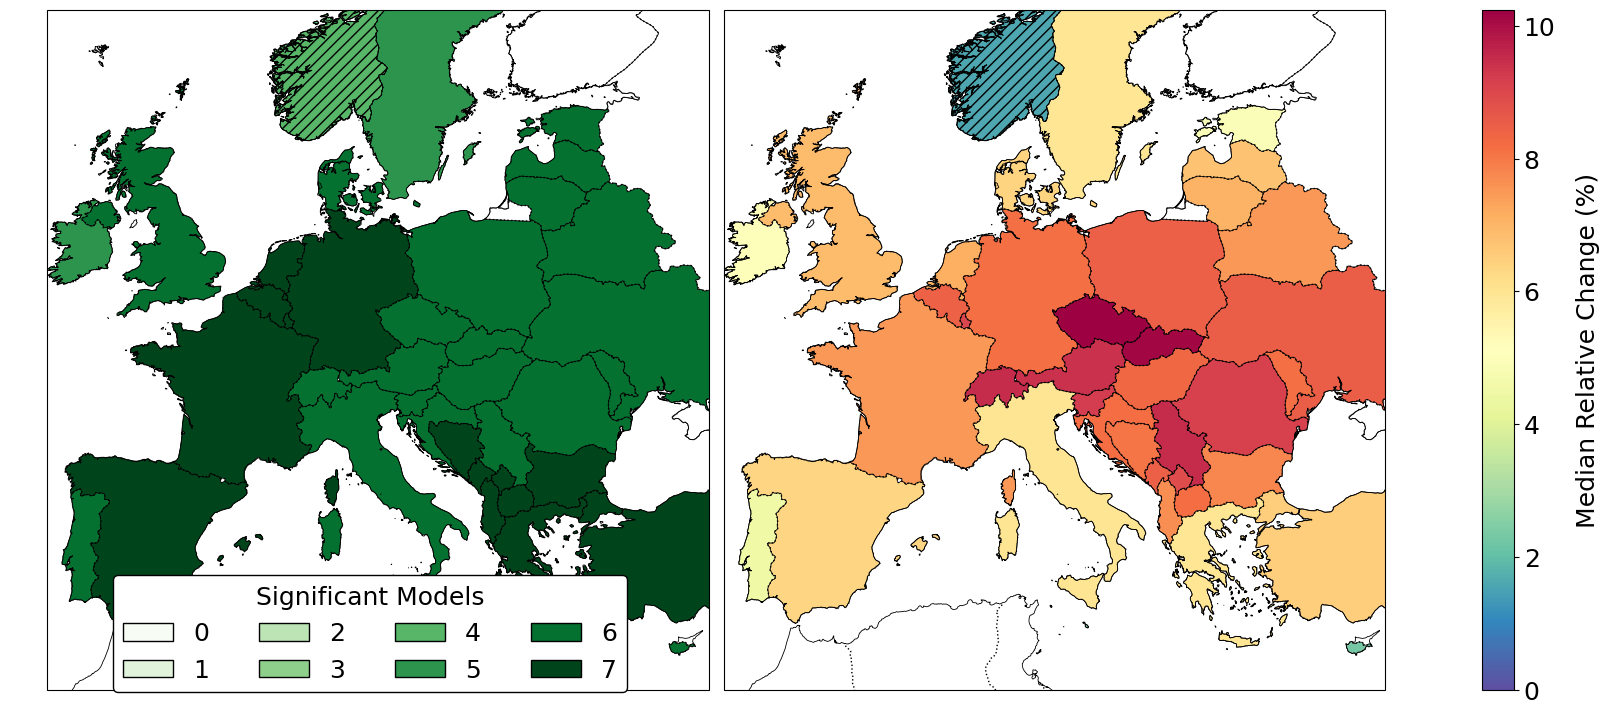

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

# ─── Data prep ─────────────────────────────────────────────────────────────
summary = pd.read_csv('solar_stats_per_model_summary.csv')

EU27   = ['AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
          'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
          'SK','SI','ES','SE','CY']
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','RU','XK']
region_codes = EU27 + extras

world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
).to_crs("EPSG:4326")

# fix a few ISO codes
world.loc[world.NAME_LONG=='France','ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Norway','ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov', na=False),'ISO_A2'] = 'XK'

base = world[world.ISO_A2.isin(region_codes)][['ISO_A2','geometry']]

# ─── Count of significant models (discrete) ────────────────────────────────
eu_count = base.merge(summary[['ISO_A2','n_models_significant']],
                      on='ISO_A2', how='left')
eu_count['n_models_significant'] = eu_count.n_models_significant.fillna(0).astype(int)
# make RU & FI missing
eu_count.loc[eu_count.ISO_A2.isin(['RU','FI']),'n_models_significant'] = np.nan

max_models = int(eu_count.n_models_significant.max(skipna=True))
cmap_count = plt.get_cmap('Greens', max_models+1)

# ─── Median relative change (continuous) ──────────────────────────────────
eu_change = base.merge(summary[['ISO_A2','median_rel_change_sig']],
                       on='ISO_A2', how='left')
eu_change['median_rel_change_sig'] = eu_change.median_rel_change_sig.fillna(0)
eu_change.loc[eu_change.ISO_A2.isin(['RU','FI']),'median_rel_change_sig'] = np.nan

vmin = eu_change.median_rel_change_sig.min()
vmax = eu_change.median_rel_change_sig.max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# lighter Reds
base_c = plt.get_cmap('Reds')(np.linspace(0,1,256))
lighter = 0.8*base_c + 0.2
cmap_change = LinearSegmentedColormap.from_list('lighterReds', lighter)
cmap="Spectral_r"

# ─── Build the figure & axes ──────────────────────────────────────────────
fig = plt.figure(figsize=(16,8))
# after creating all your axes, but before saving/showing:



# Left map (discrete)
ax1 = fig.add_axes([0.05, 0.10, 0.46, 0.85], projection=ccrs.PlateCarree())
eu_count.plot(
    column='n_models_significant',
    cmap=cmap_count,
    linewidth=0.5, edgecolor='black',
    ax=ax1, legend=False,
    missing_kwds={'color':'white'}
)
# hatch
eu_count[eu_count.n_models_significant < 5].plot(
    ax=ax1, facecolor='none', edgecolor='black',
    hatch='///', linewidth=0.5, zorder=3
)
ax1.coastlines('10m', linewidth=0.6)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.set_extent([-10.5, 35, 33, 64], ccrs.PlateCarree())
lat0 = (33+64)/2
ax1.set_aspect(1/np.cos(np.deg2rad(lat0)))
#ax1.set_title('(a) Model agreement', fontsize=16)

# Right map (continuous)
ax2 = fig.add_axes([0.52-0.047, 0.10, 0.46, 0.85], projection=ccrs.PlateCarree())
eu_change.plot(
    column='median_rel_change_sig',
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor='black',
    ax=ax2, legend=False,
    missing_kwds={'color':'white'}
)
# same hatch
eu_count[eu_count.n_models_significant < 5].plot(
    ax=ax2, facecolor='none', edgecolor='black',
    hatch='///', linewidth=0.5, zorder=3
)
ax2.coastlines('10m', linewidth=0.6)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.set_extent([-10.5, 35, 33, 64], ccrs.PlateCarree())
ax2.set_aspect(1/np.cos(np.deg2rad(lat0)))
#ax2.set_title('(b) Median change', fontsize=16)

# ─── Discrete legend under left map ───────────────────────────────────────
leg_ax = fig.add_axes([0.05, 0.15, 0.45, 0.04])
leg_ax.axis('off')
patches = [
    mpatches.Patch(
        facecolor=cmap_count(i), edgecolor='black',
        label=f"{i}"
        # Model{'s' if i!=1 else ''}
    ) for i in range(max_models+1)
]
ncols = int(np.ceil((max_models+1)/2))
leg_ax.legend(
    handles=patches, title='Significant Models',
    ncol=ncols, loc='center',
    fontsize=18, title_fontsize=18,
    frameon=True, edgecolor='black', framealpha = 1
)
leg.get_frame().set_alpha(1) 

# ─── Continuous colorbar to right of right map ───────────────────────────
cax = fig.add_axes([0.97, 0.10, 0.02, 0.85])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cb = fig.colorbar(sm, cax=cax)
cb.set_label('Median Relative Change (%)', rotation=90, labelpad=15, fontsize=18)
cb.ax.tick_params(labelsize=18)
#fig.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.10, wspace=0.01)

#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/yearly_country_conc.pdf", bbox_inches='tight', dpi=300)
plt.show()


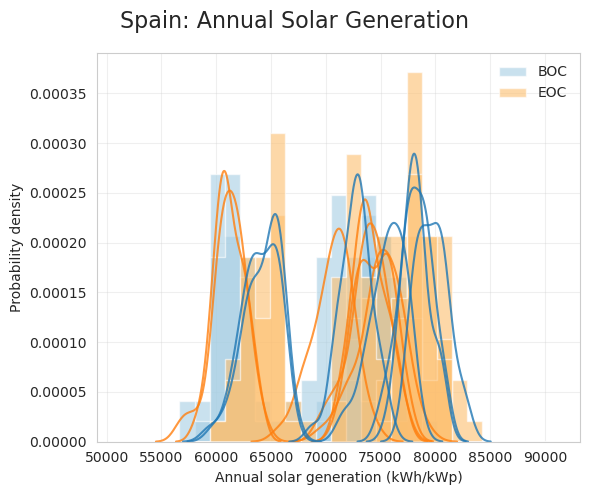

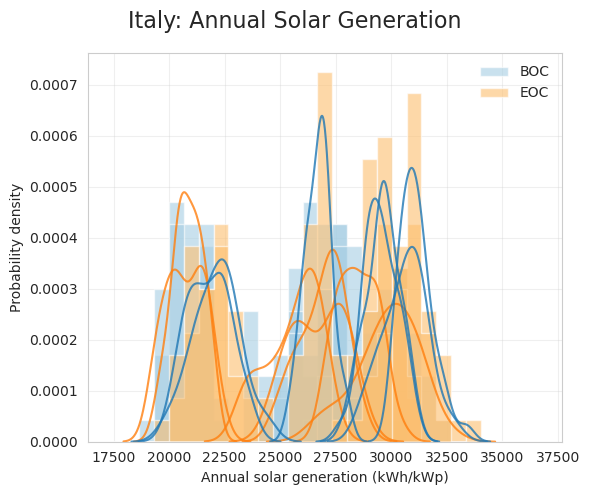

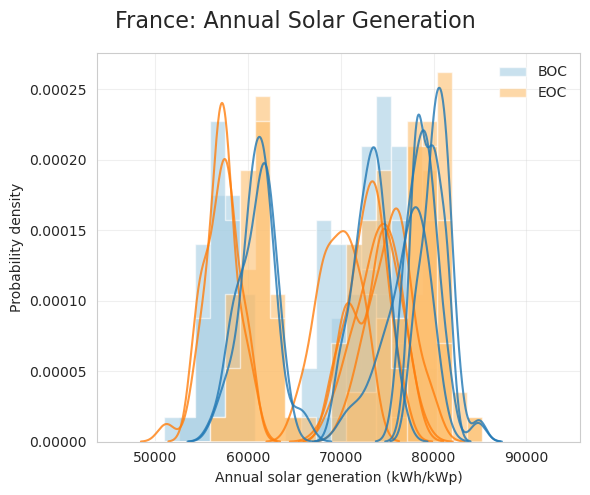

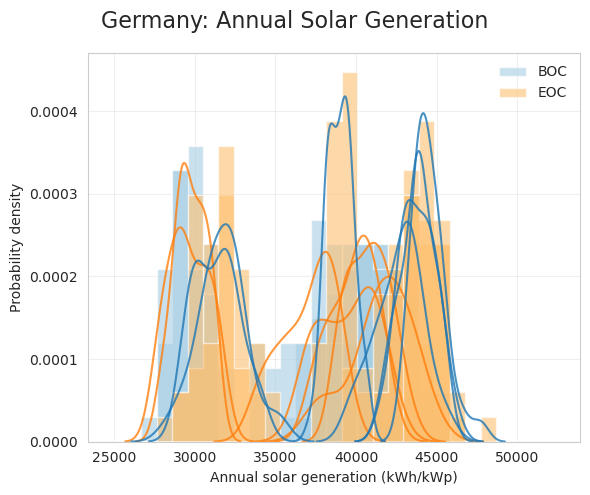

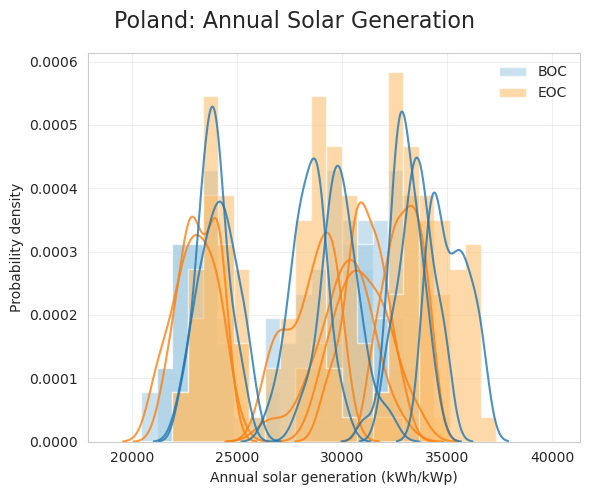

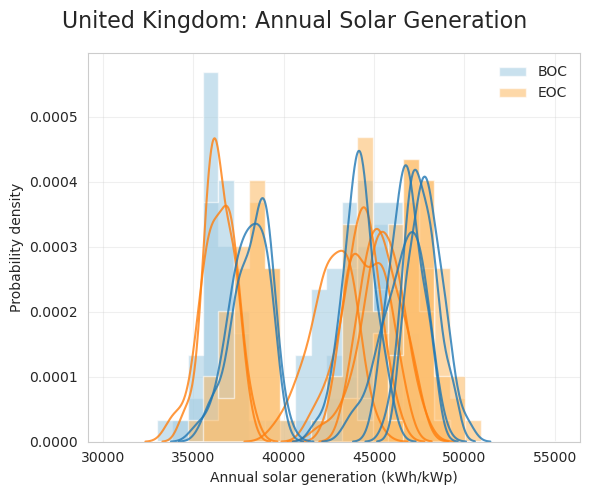

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import numpy as np

# 1) load the full yearly country‐level CSV
df = pd.read_csv("country_level_yearly_solar_power.csv")
df = df.rename(columns={"ADM0_A3":"ISO3","specific generation":"power"})

# build ISO3→ISO2 map
iso2_to_iso3 = {c.alpha_2:c.alpha_3 for c in pycountry.countries}
iso3_to_iso2 = {v:k for k,v in iso2_to_iso3.items()}
df["ISO_A2"] = df["ISO3"].map(iso3_to_iso2)

# 2) pick your six and map to names
selected_iso2 = ["ES","IT","FR","DE","PL","GB"]
df = df[df.ISO_A2.isin(selected_iso2)].copy()
iso2_to_name = {c.alpha_2:c.name for c in pycountry.countries}
iso2_to_name["GB"] = "United Kingdom"

boc_hist = "#a6cee3"   # soft light blue
eoc_hist = "#fdbf6f"   # soft light orange
# Darker colors for KDE lines
boc_line = "#ff7f0e"   # dark blue
eoc_line = "#1f77b4"   # dark orange

# 3) loop per country
for iso2 in selected_iso2:
    cname = iso2_to_name[iso2]
    df_ct = df[df.ISO_A2==iso2]

    boc = df_ct[df_ct.period=="historical"]
    eoc = df_ct[df_ct.period=="ssp585"]

    # compute common bins
    all_p = pd.concat([boc.power, eoc.power])
    bins = np.linspace(all_p.min()*0.9, all_p.max()*1.1, 30)

    fig, ax = plt.subplots(figsize=(6,5))
    fig.suptitle(f"{cname}: Annual Solar Generation", fontsize=16)

    # plot all BOC models in blue
    first = True
    for model in boc.model.unique():
        vals = boc[boc.model==model].power
        ax.hist(vals, bins=bins, density=True, histtype="stepfilled",
                color=boc_hist, lw=1, alpha=0.6,
                label="BOC" if first else None)
        sns.kdeplot(vals, ax=ax, color=boc_line, lw=1.5, alpha=0.8)
        first = False

    # plot all EOC models in orange
    first = True
    for model in eoc.model.unique():
        vals = eoc[eoc.model==model].power
        ax.hist(vals, bins=bins, density=True, histtype="stepfilled",
                color=eoc_hist, lw=1, alpha=0.6,
                label="EOC" if first else None)
        sns.kdeplot(vals, ax=ax, color=eoc_line, lw=1.5, alpha=0.8)
        first = False

    ax.set_xlabel("Annual solar generation (kWh/kWp)")
    ax.set_ylabel("Probability density")
    ax.grid(alpha=0.3)

    # single legend
    ax.legend(loc="upper right", frameon=False)

    plt.tight_layout()
    plt.show()
